In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jul 23 01:31:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [10]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import missingno as msno
import re

# import xlrd
import warnings
warnings.filterwarnings('ignore')
# plt.style.use('seaborn') #그래프 스타일

from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, ActivityRegularization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50, ResNet101V2,EfficientNetB0, InceptionV3

In [5]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = '/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train'

datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   validation_split=0.1,
                                   )

In [6]:
train_generator = datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    class_mode='binary',
                                                    subset='training')

valid_generator = datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=16,
                                                   class_mode='binary',
                                                   subset='validation')

Found 828 images belonging to 2 classes.
Found 91 images belonging to 2 classes.


In [ ]:
#전이학습 모델
from keras.layers import Dense
base_model = ResNet101V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(.2)(x)
x = Dense(512, activation='relu')(x)
x = ActivityRegularization(l1=1e-5, l2=1e-4)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# base_model = ResNet101V2(include_top=False,weights="imagenet")

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)  # Dropout 층을 추가합니다.
# x = ActivityRegularization(l1=1e-5, l2=1e-4)(x)  # L1, L2 정규화를 추가합니다.
# predictions = Dense(1, activation='sigmoid')(x)
# model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

In [8]:
from keras.callbacks import ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='./model/resnent101v2_model.h5', monitor='val_loss', verbose=1, save_best_only=True,  mode='auto')


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples // valid_generator.batch_size,
                    epochs=20,
                    callbacks=[early_stop, model_checkpoint])  # EarlyStopping 콜백을 추가합니다.

Epoch 1/20
51/51 [==============================] - ETA: 0s - loss: 14.4600 - accuracy: 0.1096
Epoch 1: val_loss improved from inf to 42010329028932990352228352.00000, saving model to ./model/resnent101v2_model.h5
51/51 [==============================] - 118s 907ms/step - loss: 14.4600 - accuracy: 0.1096 - val_loss: 42010329028932990352228352.0000 - val_accuracy: 0.1000
Epoch 2/20
51/51 [==============================] - ETA: 0s - loss: 93.3944 - accuracy: 0.1084
Epoch 2: val_loss improved from 42010329028932990352228352.00000 to 329680800.00000, saving model to ./model/resnent101v2_model.h5
51/51 [==============================] - 15s 290ms/step - loss: 93.3944 - accuracy: 0.1084 - val_loss: 329680800.0000 - val_accuracy: 0.1125
Epoch 3/20
51/51 [==============================] - ETA: 0s - loss: 427.5143 - accuracy: 0.1084
Epoch 3: val_loss improved from 329680800.00000 to 84117376.00000, saving model to ./model/resnent101v2_model.h5
51/51 [==============================] - 15s 290ms/

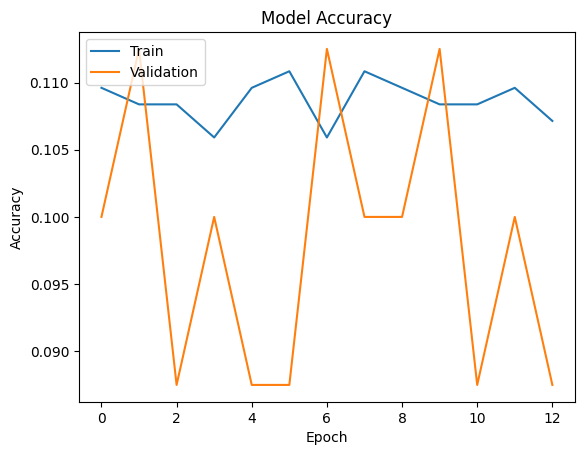

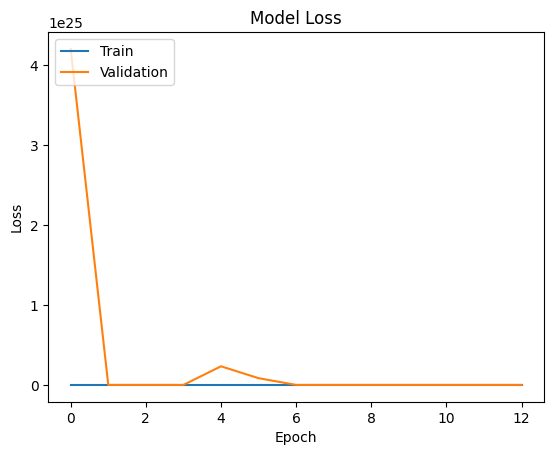

In [9]:
# accuracy 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# loss 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
# 코드 최적화

from keras.preprocessing.image import ImageDataGenerator
train_dir = '/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train'

datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   validation_split=0.1,
                                   )



train_generator = datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    class_mode='binary',
                                                    subset='training')

valid_generator = datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=16,
                                                   class_mode='binary',
                                                   subset='validation')



#전이학습 모델
from keras.layers import Dense
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(.2)(x)
# x = Dense(512, activation='relu')(x)
# x = ActivityRegularization(l1=1e-5, l2=1e-4)(x)
# x = Dense(256, activation='relu')(x)
# predictions = Dense(1, activation='sigmoid')(x)
# model = Model(inputs=base_model.input, outputs=predictions)


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  # Changed the dropout rate
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Added a new dropout layer
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)



# base_model = ResNet101V2(include_top=False,weights="imagenet")

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)  # Dropout 층을 추가합니다.
# x = ActivityRegularization(l1=1e-5, l2=1e-4)(x)  # L1, L2 정규화를 추가합니다.
# predictions = Dense(1, activation='sigmoid')(x)
# model = Model(inputs=base_model.input, outputs=predictions)



early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='./model/iceptionV3_model.h5', monitor='val_loss', verbose=1, save_best_only=True,  mode='auto')


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples // valid_generator.batch_size,
                    epochs=20,
                    callbacks=[early_stop, model_checkpoint])  # EarlyStopping 콜백을 추가합니다.

Found 828 images belonging to 2 classes.
Found 91 images belonging to 2 classes.
Epoch 1/20
51/51 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8756
Epoch 1: val_loss improved from inf to 227.14023, saving model to ./model/iceptionV3_model.h5
51/51 [==============================] - 57s 340ms/step - loss: 0.3695 - accuracy: 0.8756 - val_loss: 227.1402 - val_accuracy: 0.9125
Epoch 2/20
51/51 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9076
Epoch 2: val_loss improved from 227.14023 to 5.35829, saving model to ./model/iceptionV3_model.h5
51/51 [==============================] - 14s 277ms/step - loss: 0.2246 - accuracy: 0.9076 - val_loss: 5.3583 - val_accuracy: 0.9125
Epoch 3/20
51/51 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9409
Epoch 3: val_loss improved from 5.35829 to 0.32243, saving model to ./model/iceptionV3_model.h5
51/51 [==============================] - 14s 271ms/step - loss: 0.1948 - accuracy: 

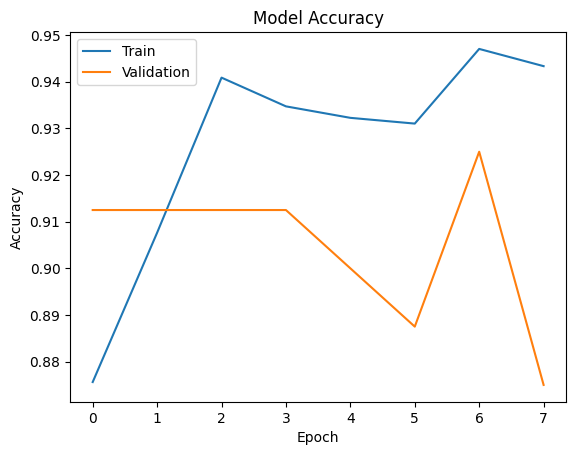

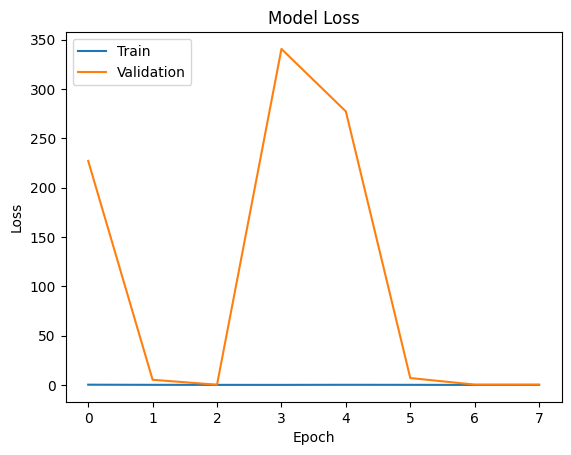

In [27]:
# accuracy 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# loss 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 1s/step


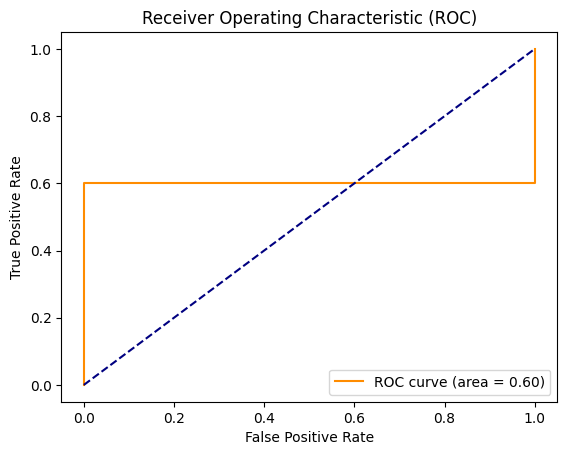

In [28]:
from sklearn.metrics import roc_curve, auc

# 검증용 데이터에 대한 예측값 계산
val_images, val_labels = next(valid_generator)
val_pred = model.predict(val_images)

# auc, roc 그래프 출력
fpr, tpr, thresholds = roc_curve(val_labels, val_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 0s 28ms/step


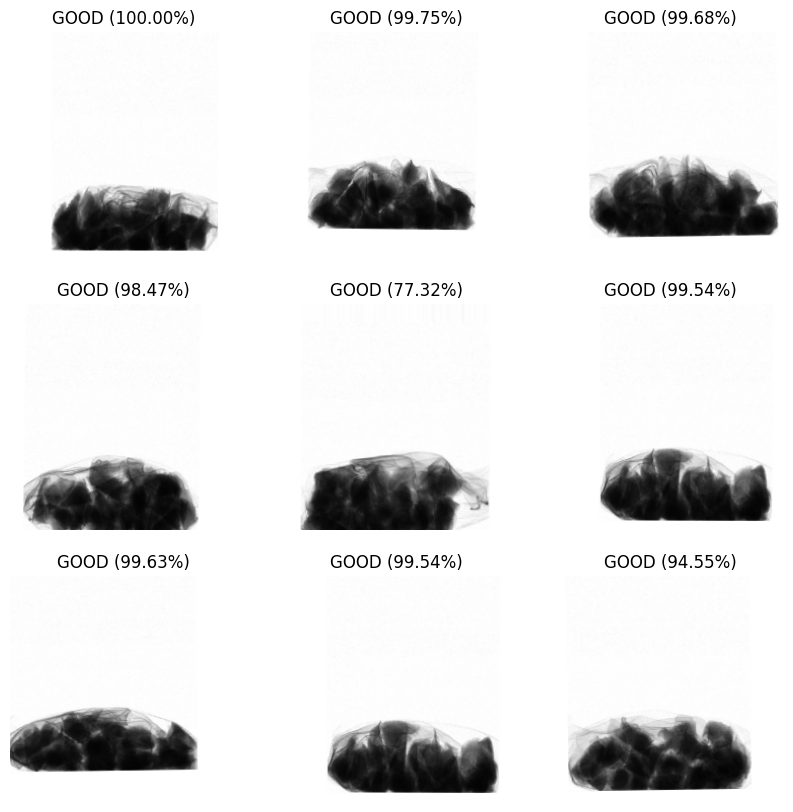

In [29]:
import matplotlib.pyplot as plt

# 검증 데이터에서 무작위로 이미지와 예측값 출력
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes = axes.ravel()
for i in np.arange(0, 9):
    index = np.random.randint(0, len(val_images))
    image = val_images[index]
    axes[i].imshow(image)
    axes[i].axis('off')
    pred = model.predict(np.expand_dims(image, axis=0))[0][0]
    label = val_labels[index]
    if pred < 0.5:
        axes[i].set_title('NG ({:.2f}%)'.format((1-pred) * 100))
    else:
        axes[i].set_title('GOOD ({:.2f}%)'.format(pred * 100))
plt.show()


1/1 [==============================] - 0s 465ms/step


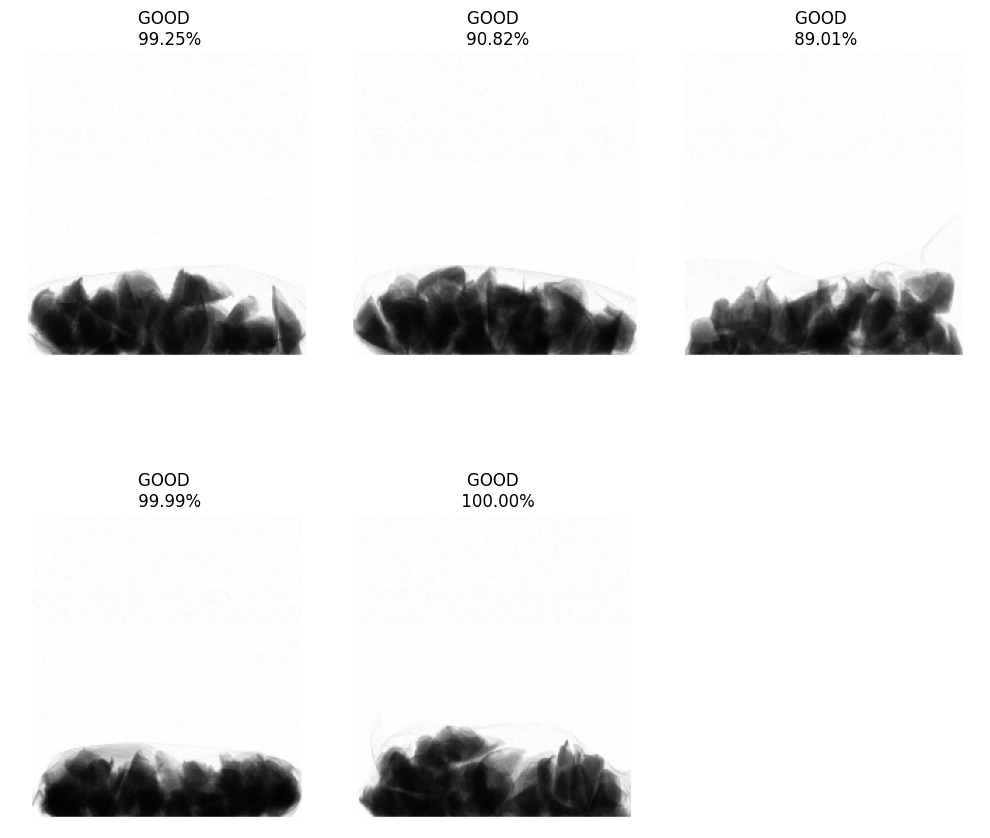

In [30]:
import cv2
import os
import glob

valid_dir = '/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/valid'

# Load all image file paths
image_files = glob.glob(os.path.join(valid_dir, '*'))

# Load all images
val_images = []
for image_file in image_files:
    image = cv2.imread(image_file)
    image = cv2.resize(image, (224, 224))
    val_images.append(image)
val_images = np.array(val_images)

# Predict on all validation images
val_pred = model.predict(val_images / 255.)  # Normalize images

# Calculate the number of rows and columns for the plot
n_images = len(val_images)
n_cols = 3
n_rows = n_images // n_cols + (n_images % n_cols != 0)

# Display all images with predictions
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 10))
axes = axes.ravel()
for i in range(n_images):
    image = val_images[i]
    axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert color space from BGR to RGB
    axes[i].axis('off')
    pred = val_pred[i][0]
    if pred < 0.5:
        axes[i].set_title('NG \n {:.2f}%'.format((1-pred) * 100))
    else:
        axes[i].set_title('GOOD \n {:.2f}%'.format(pred * 100))

# Remove extra subplots
for i in range(n_images, n_rows * n_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


# 전이학습 2개 앙상블(mobiblenet, Resnet)

In [38]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet_v2 import ResNet101V2
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Average
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

train_dir = '/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train'

datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=1,
                                   validation_split=0.2,
                                   )



train_generator = datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    class_mode='binary',
                                                    subset='training')

valid_generator = datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=16,
                                                   class_mode='binary',
                                                   subset='validation')


# Define the input shape
input_shape = (224, 224, 3)
model_input = Input(shape=input_shape)

# Base model 1
base_model1 = MobileNetV2(include_top=False, weights='imagenet', input_tensor=model_input)
x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dropout(0.2)(x1)
predictions1 = Dense(1, activation='sigmoid')(x1)
model1 = Model(inputs=model_input, outputs=predictions1)

# Base model 2
base_model2 = ResNet101V2(include_top=False, weights='imagenet', input_tensor=model_input)
x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)
x2 = Dropout(0.2)(x2)
predictions2 = Dense(1, activation='sigmoid')(x2)
model2 = Model(inputs=model_input, outputs=predictions2)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint1 = ModelCheckpoint(filepath='./model/mobilenet_model.h5', monitor='val_loss', verbose=1, save_best_only=True,  mode='auto')
model_checkpoint2 = ModelCheckpoint(filepath='./model/resnet_model.h5', monitor='val_loss', verbose=1, save_best_only=True,  mode='auto')

# Compile models
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train models
history1 = model1.fit(train_generator, epochs=20, validation_data=valid_generator, callbacks=[early_stop, model_checkpoint1])
history2 = model2.fit(train_generator, epochs=20, validation_data=valid_generator, callbacks=[early_stop, model_checkpoint2])

# Ensemble
def ensemble(models, model_input):
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    model = Model(model_input, y, name='ensemble')
    return model

ensemble_model = ensemble([model1, model2], model_input)


Found 736 images belonging to 2 classes.
Found 183 images belonging to 2 classes.


Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9239
Epoch 1: val_loss improved from inf to 4.12759, saving model to ./model/mobilenet_model.h5
46/46 [==============================] - 41s 308ms/step - loss: 0.2003 - accuracy: 0.9239 - val_loss: 4.1276 - val_accuracy: 0.1038
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9715
Epoch 2: val_loss improved from 4.12759 to 0.43619, saving model to ./model/mobilenet_model.h5
46/46 [==============================] - 13s 288ms/step - loss: 0.0700 - accuracy: 0.9715 - val_loss: 0.4362 - val_accuracy: 0.8962
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.9810
Epoch 3: val_loss did not improve from 0.43619
46/46 [==============================] - 13s 285ms/step - loss: 0.0478 - accuracy: 0.9810 - val_loss: 10.7232 - val_accuracy: 0.1038
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0

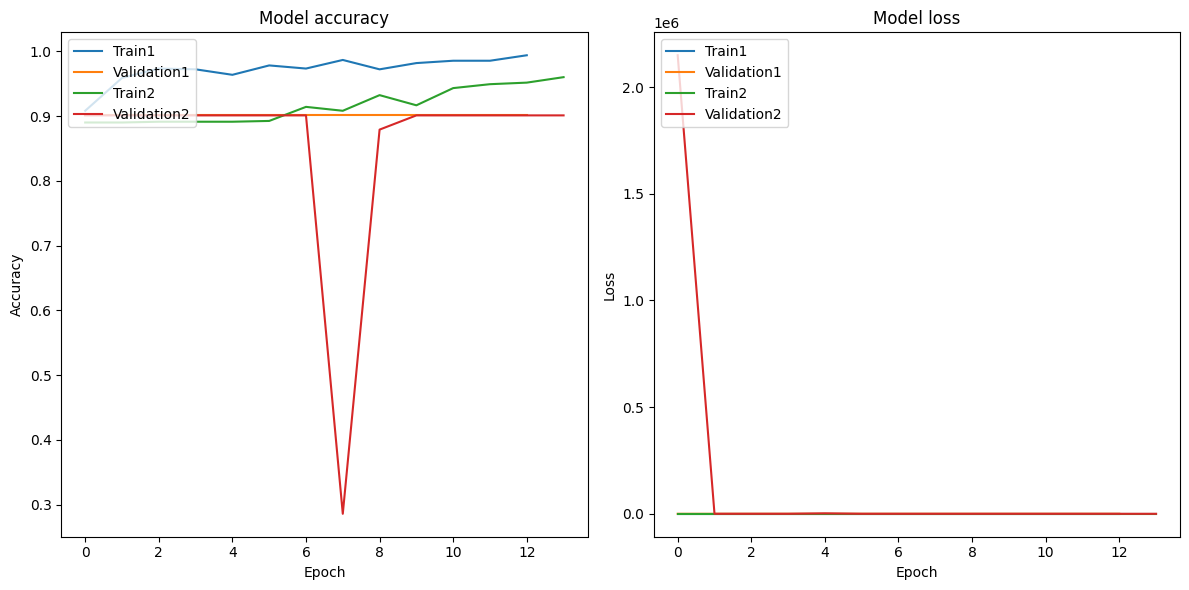

In [36]:
# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train1', 'Validation1', 'Train2', 'Validation2'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train1', 'Validation1', 'Train2', 'Validation2'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 32ms/step


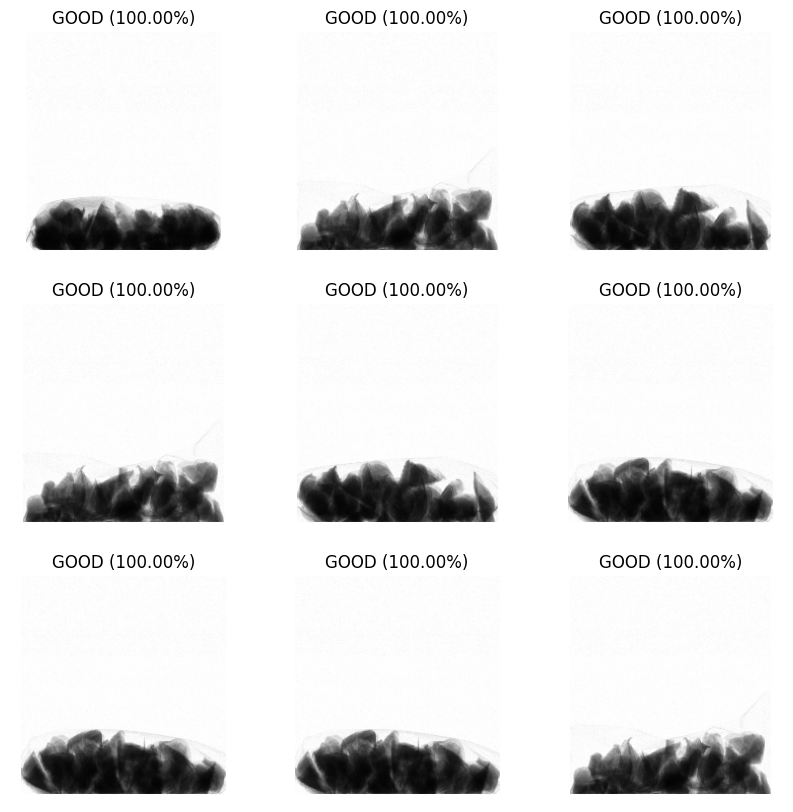

In [37]:
import matplotlib.pyplot as plt

# 검증 데이터에서 무작위로 이미지와 예측값 출력
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes = axes.ravel()
for i in np.arange(0, 9):
    index = np.random.randint(0, len(val_images))
    image = val_images[index]
    axes[i].imshow(image)
    axes[i].axis('off')
    pred = ensemble_model.predict(np.expand_dims(image, axis=0))[0][0]
    label = val_labels[index]
    if pred < 0.5:
        axes[i].set_title('NG ({:.2f}%)'.format((1-pred) * 100))
    else:
        axes[i].set_title('GOOD ({:.2f}%)'.format(pred * 100))
plt.show()
